# <u><center>Predicting Programming Language on GitHub Using NLP<center><u>

### <center>Reported by: Ella Xu, Jerry Nolf, Matthew Luna, and Nathan Sharick <center>
#### <center>Codeup - Innis Cohort - May 17, 2022<center>

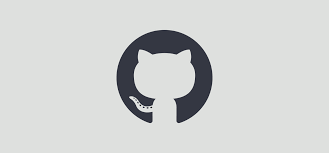

---

## <u>Project Description:<u>

Most of the code hosting platforms for opensource projects consider the README file as the project introduction. As it is the first document seen by the reader, such a document needs to be crafted with care. The goal of this project is to predict the programming language for 100 repository by scraping, analyze the repository's README file contents. Using these datasets from 100 README's we were able to predict what programming language was used based on the composition of the README text.

### Project Goal:

- The goal of this project was to build a classification model that can predict the programming language of a repository based on the text of the repository's README.md file. 

### Imports

In [1]:
from requests import get
from bs4 import BeautifulSoup
import pandas as pd
import unicodedata
import re
import json
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')
import matt_prepare
import visualization
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## <u>Data Acquisition, Data Cleaning, and Data Preparation:<u>

- Web scraping methods were used to create a list of github username/repositories that included more than 300 repositories. The repositoriy names were pulled from github's top trending repositories, most forked repositories, and most stared repositories as of 05/13/ 2022.

- The list of repositories was put into the acompanying acquire.py file which creates a list of dictionaries that includes the name of the repository, the programming language used in the repository, and the content of the readme file for each repository in the list, and saves it as a .json file. The .json file is required to reproduce this project with this notebook and can be created by saving the acquire.py file in your local repository and running 'python acquire.py' from the terminal.

- Once the .json file is saved in the local directory is can be puled into the notebook, cleaned and prepared using the clean_df function located in the matt_prepare.py file. This function performs the following cleaning/preparation actions:
    - It uses pandas to read the file into the notebook
    
    - It cleans the data by normalizing it, changing all words to lower case, and removing any characters that are not letters, numbers, or whitespace
    
    - It tokenizes the words in the readme content using a toktok tokenizer
    
    - It removes standard english stopwords from the readme content
    
    - It then outputs a dataframe with the following columns:
        - name of the repository
        
        - Programming language of the repository
        
        - The raw readme contents
        
        - The cleaned readme content
        
        - The cleaned readme content that has been stemmed using a PorterStemmer
        
        - The cleaned readme content that has been lemmatized using a WordNetLemmatizer
        
        - The character count for the readme content
        
        - The word count for the readme content
        
        - A 'top_five' column that has the top five programming languages identified by name and any other programming language identified as 'other'
        
- The dataset is then split into train, validate, and test sets using the split_data function located in the matt_prepare.py file which returns a train set with 56%, validate set with 24%, and test set with 20% of the original data frame


In [2]:
# Pull in, clean, and prepare the dataset using the clean_df function
df = matt_prepare.clean_df()
# View the first five rows of the returned dataframe
df.head(2)

,repo,language,readme_contents,clean,stemmed,lemmatized,character_count,word_count,top_five_languages
0,gocodeup/codeup-setup-script,Shell,# Codeup Setup Script\n\nSetup script for Code...,codeup setup script setup script codeup studen...,codeup setup script setup script codeup studen...,codeup setup script setup script codeup studen...,1062,119,other
1,gocodeup/movies-application,JavaScript,"# Movies Application\n\nFor this project, we w...",movies application project building single pag...,movi applic project build singl page movi appl...,movie application project building single page...,2888,411,JavaScript


In [3]:
# Split the dataset into train, validate, and test using the split_data function
train, validate, test = matt_prepare.split_data(df)

The split of this data results in the following:
------------------------------------------------
The train dataset contains 150 rows.
The validate dataset contains 65 rows.
The test dataset contains 54 rows.
All split datasets contain 9 columns.


---

## <u>Data Exploration<u>

- Data exploration comments.....

**Question 1:** What are the most common languages from the repos we explored?

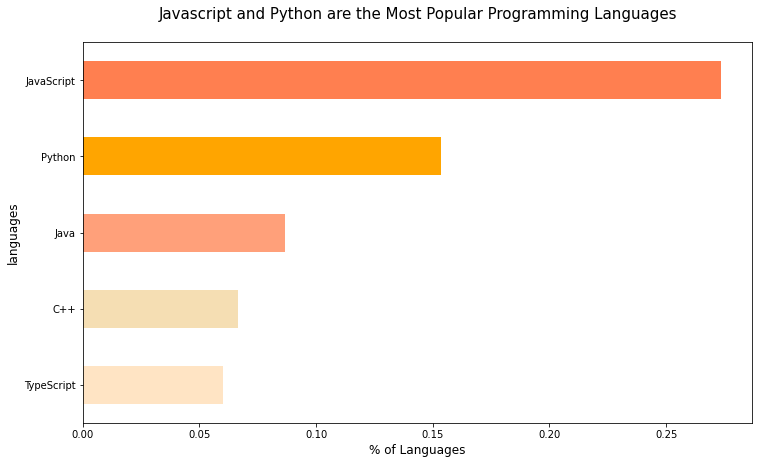

In [4]:
# Pull function from visualization.py to visualize question #1
visualization.top_languages(train)

***Takeaways: Javascript and Python are two most frequently used languages.***

**Question 2:** What are the most common words across all languages' readmes?

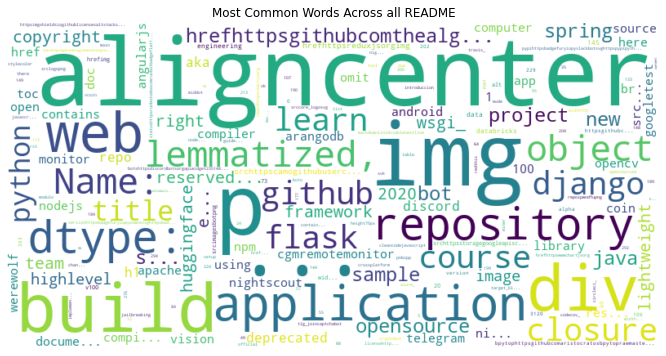

In [5]:
# Pull function from visualization.py to visualize question #2
visualization.word_cloud(train)

***Takeaways: There are popular words across top languages readme such as aligncenter, application, build, web, p....***

**Question 3:** Is there a correlation between character count and word count? 

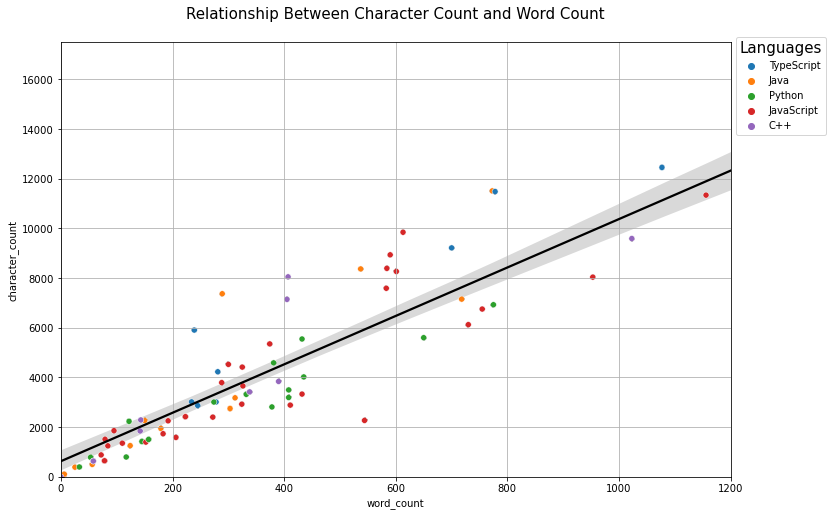

In [6]:
# Pull function from visualization.py to visualize question #3
visualization.char_word(train)

#### Statistical Testing (Correlation):


#### Hypothesis:

 - H0: There is no linear relationship between character count and word count of a READme.

 - Ha: There is a linear relationship between character count and word count of a READme.

A Pearson's r statistical test will allow us to verify our beliefs...

In [7]:
# Pull function from visualization.py for stats testing of question #3
visualization.question3_spearman_stats(train)

The findings of the Spearman's test are as follows:
----------------------------------------------------------------------
r-value = 0.956
p-value = 0.0
From the output, we can conclude that the Spearman rank correlation is
0.956 suggesting a strong positive correlation while the corresponding
p-value is 0.0 meaning that this finding is statistically significant.


***Takeaways: There is a strong positive correlation between character count and word count.*** 

**Question 4:** Does the length of READme differ between languages?

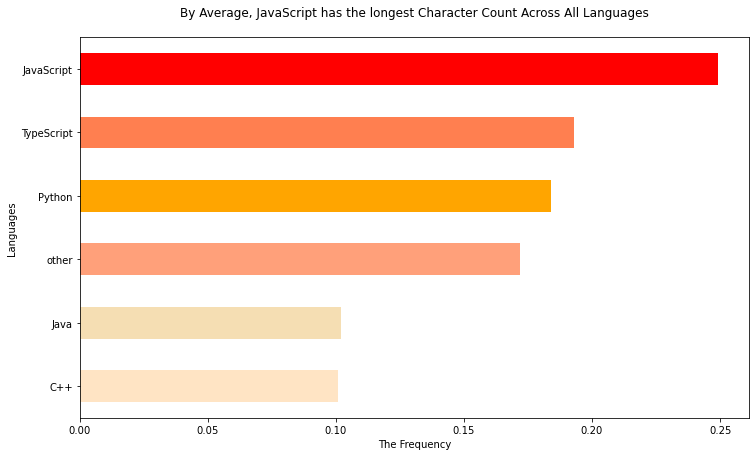

In [8]:
# Pull function from visualization.py to visualize the first part of 
# question #4
visualization.char_count(train)

#### Statistical Testing (Kruskal-Wallis):


#### Hypothesis:

 - H0: The population median of character count for all programming languages is equal.

 - Ha: The population median of character count for all programming languages is NOT equal.

Considering we require the non-parametric equivalent of an ANOVA test, a Kruskal-Wallis test will be performed...

In [9]:
# Pull function from visualization.py for stats testing the first part
# of question #4
visualization.question4_char_stats(train)

The findings of the Kruskal-Wallis test are as follows:
-------------------------------------------------------------------------
H-statistic = 9.142
p-value = 0.104
With an p-value of 0.104, we reject the null hypothesis that the
population median for character count is equal for all languages.


***Takeaways: By Average, JavaScript has the longest character count across all languages followed by TypeScript. Our statistical testing helps us verify that the population medians of word count for each languageis not equal.***

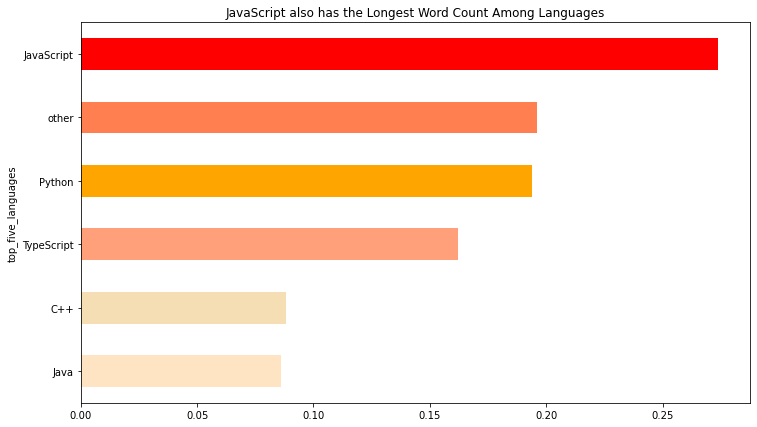

In [10]:
# Pull function from visualization.py to visualize the second part of 
# question #4
visualization.word_count(train)

#### Statistical Testing (Kruskal-Wallis):


#### Hypothesis:

 - H0: The population median of word count for all programming languages is equal.

 - Ha: The population median of word count for all programming languages is NOT equal.

Once again, a Kruskal-Wallis test will be performed considering the dataset's non normal distribution...

In [11]:
# Pull function from visualization.py for stats testing the second part
# of question #4
visualization.question4_word_stats(train)

The findings of the Kruskal-Wallis test are as follows:
-------------------------------------------------------------------------
H-statistic = 7.153
p-value = 0.21
With an p-value of 0.21, we reject the null hypothesis that the
population median for word count is equal for all languages.


***Takeaways: JavaScript has has the longest word count across all languages. This is followed by our 'other' group and then by python. Comparing word and character count, python has longer word count while Typescript has longer character count.***

## <u>Takeaways from Data Exploration:<u>

- Javascript and Python are two most frequently used languages.

- There are popular words across top languages readme such as aligncenter, application, build, web, p....

- There is a positive correlation between character count and word count. Python and JavaScript have the highest counts. In the plotted graphs, there do appear to be differences in average character and word count but statistical testing shows that these differences are not statistically significant.

- JavaScript has has the longest word count across all languages. This is followed by our 'other' group and then by python. Comparing word and character count, python has longer word count while Typescript has longer character count.


---

## <u>Data Preparation for Modeling:<u>

- Before proceding with modeling the data from each of the split groups was assigned to variable that can be used with the vectorizers and the classification models during the modeling phase

- The cleaned and lemmatized readme contents from each of the split groups was assigned to an X variable for the group

- The engineered language classification column (all language identifers were either one of the top five from the dataset or assigned as 'other') from each split dataset was assigned to a y variable for the group

In [12]:
# Assign the cleaned and lemmatized readme contents from the train set to the X_train variable
X_train = train.lemmatized
# Assign the engineered language classification value from the train set to the y_train variable
y_train = train.top_five_languages
# Assign the cleaned and lemmatized readme contents from the validate set to the X_val variable
X_val = validate.lemmatized
# Assign the engineered language classification value from the validate set to the y_val variable
y_val = validate.top_five_languages
# Assign the cleaned and lemmatized readme contents from the test set to the X_test variable
X_test = test.lemmatized
# Assign the engineered language classification value from the test set to the y_test variable
y_test = test.top_five_languages

---

## <u>Modeling:<u>

- Two types of vectorizers (CountVectorizer and TfidfVectorizer) were used to preprocess the data prior to running the classification modeling

- Over 100 models were developed using both sets of vectorized data, multiple classification model types (decision tree, logistic regression, random forest, etc) and a full range of hyperperameters for each model type evaluated.

- The top eight models with their optimal hyperparameters and vectorized datasets are seen below

- Each model's accuracy score with train and validate datasets is displayed below the code cell.

- Baseline was calculated using the most frequent language from the train dataset divided by the total number of observations in the train dataset which gives the accuracy of predicting the most common programming language category

In [13]:
# Baseline Calculation 
train.top_five_languages.value_counts()

other         54
JavaScript    41
Python        23
Java          13
C++           10
TypeScript     9
Name: top_five_languages, dtype: int64

In [14]:
# Calculate the baseline accuracy
print(f' Baseline Accuracy: {54 / train.top_five_languages.shape[0]}')

 Baseline Accuracy: 0.36


In [15]:
## Modeling with unigrams ## 

# Create the CountVectorizer object
cv = CountVectorizer()
# Fit the CountVectorizer with the train data and transform the train data
X_bow = cv.fit_transform(X_train)
# Transform the validate data with the CountVectorizer
X_bow_val = cv.transform(X_val)

# Create the TfidfVectorizer
tfidf = TfidfVectorizer()
# Fit the TfidfVectorizer with the train data and transform the train data
X_tfidf = tfidf.fit_transform(X_train)
# Transform the validate data
X_tfidf_val = tfidf.transform(X_val)

In [16]:
# Create the decision tree classifier object with a max depth of 15 and a random state of 123 for reproducibility
tree = DecisionTreeClassifier(max_depth=15, random_state=123)
# Fit the decision tree with the CountVectorizer train data
tree.fit(X_bow, y_train)
# Calculate the accuracy score of the decision tree with countvectorizer train and validate data
print(f' Model: Decision Tree - max depth = 15, Unigrams, CountVectorizer')
print('================================================================')
print(f' Train data accuracy score: {round(tree.score(X_bow, y_train),3)}')
print(f' Validate data accuracy score: {round(tree.score(X_bow_val, y_val),3)}')

 Model: Decision Tree - max depth = 15, Unigrams, CountVectorizer
 Train data accuracy score: 0.967
 Validate data accuracy score: 0.631


In [17]:
# Create the decision tree classifier object with a max depth of 15 and a random state of 123 for reproducibility
tree = DecisionTreeClassifier(max_depth=15, random_state=123)
# Fit the decision tree with the tfidfvectorizer train data
tree.fit(X_tfidf, y_train)
# Calculate the accuracy score of the decision tree with tfidfvectorizer train and validate data
print(f' Model: Decision Tree - max depth = 15, Unigrams, TfidfVectorizer')
print('================================================================')
print(f' Train data accuracy score: {round(tree.score(X_tfidf, y_train),3)}')
print(f' Validate data accuracy score: {round(tree.score(X_tfidf_val, y_val),3)}')

 Model: Decision Tree - max depth = 15, Unigrams, TfidfVectorizer
 Train data accuracy score: 0.98
 Validate data accuracy score: 0.6


In [18]:
# Create the logistic regression classifier object with a C value of 0.05 and a random state of 123 for reproducability
# and fit it with the countvectorizer train data
lm = LogisticRegression(C=0.05, random_state=123).fit(X_bow, y_train)
# Calculate the accuracy score of the model with countvectorizer train and validate data
print(f' Model: Logistic Regression - C = 0.05, Unigrams, CountVectorizer')
print('================================================================')
print(f' Train data accuracy score: {round(lm.score(X_bow, y_train),3)}')
print(f' Validate data accuracy score: {round(lm.score(X_bow_val, y_val),3)}')

 Model: Logistic Regression - C = 0.05, Unigrams, CountVectorizer
 Train data accuracy score: 0.953
 Validate data accuracy score: 0.646


In [19]:
# Create the logistic regression classifier object with a C value of 10 and a random state of 123 for reproducability
# and fit it with the tfidfvectorizer train data
lm = LogisticRegression(C=10, random_state=123).fit(X_tfidf, y_train)
# Calculate the accuracy score of the model with tfidfvectorizer train and validate data
print(f' Model: Logistic Regression - C = 10, Unigrams, TfidfVectorizer')
print('================================================================')
print(f' Train data accuracy score: {round(lm.score(X_tfidf, y_train),3)}')
print(f' Validate data accuracy score: {round(lm.score(X_tfidf_val, y_val),3)}')

 Model: Logistic Regression - C = 10, Unigrams, TfidfVectorizer
 Train data accuracy score: 0.993
 Validate data accuracy score: 0.692


---

In [20]:
## Modeling with unigrams and bigrams ##

# Create the CountVectorizer object with a ngram range of 1, 2 to include both unigrams and bigrams
cv = CountVectorizer(ngram_range=(1,2))
# Fit the CountVectorizer with the train data and transform the train data
X_bow = cv.fit_transform(X_train)
# Transform the validate data 
X_bow_val = cv.transform(X_val)

# Create the TfidfVectorizer with a ngram range of 1, 2 to include both unigrams and bigrams
tfidf = TfidfVectorizer(ngram_range=(1,2))
# Fit the TfidfVectorizer with the train data and transform the train data
X_tfidf = tfidf.fit_transform(X_train)
# Transform the validate data
X_tfidf_val = tfidf.transform(X_val)

In [21]:
# Create the decision tree classifier object with a max depth of 20 and a random state of 123 for reproducibility
tree = DecisionTreeClassifier(max_depth=20, random_state=123)
# Fit the decision tree with the unigram/bigram CountVectorizer train data
tree.fit(X_bow, y_train)
# Calculate the accuracy score of the decision tree with unigram/bigram countvectorizer train and validate data
print(f' Model: Decision Tree - max depth = 20, Unigrams and Bigrams, CountVectorizer')
print('=============================================================================')
print(f' Train data accuracy score: {round(tree.score(X_bow, y_train),3)}')
print(f' Validate data accuracy score: {round(tree.score(X_bow_val, y_val),3)}')

 Model: Decision Tree - max depth = 20, Unigrams and Bigrams, CountVectorizer
 Train data accuracy score: 0.993
 Validate data accuracy score: 0.585


In [22]:
# Create the decision tree classifier object with a max depth of 10 and a random state of 123 for reproducibility
tree = DecisionTreeClassifier(max_depth=10, random_state=123)
# Fit the decision tree with the unigram/bigram tfidfvectorizer train data
tree.fit(X_tfidf, y_train)
# Calculate the accuracy score of the decision tree with unigram/bigram tfidfvectorizer train and validate data
print(f' Model: Decision Tree - max depth = 10, Unigrams and Bigrams, TfidfVectorizer')
print('=============================================================================')
print(f' Train data accuracy score: {round(tree.score(X_tfidf, y_train),3)}')
print(f' Validate data accuracy score: {round(tree.score(X_tfidf_val, y_val),3)}')

 Model: Decision Tree - max depth = 10, Unigrams and Bigrams, TfidfVectorizer
 Train data accuracy score: 0.88
 Validate data accuracy score: 0.631


In [23]:
# Create the logistic regression classifier object with a C value of 0.1 and a random state of 123 for reproducability
# and fit it with the unigram/bigram countvectorizer train data
lm = LogisticRegression(C=0.1, random_state=123).fit(X_bow, y_train)
# Calculate the accuracy score of the model with unigram/bigram countvectorizer train and validate data
print(f' Model: Logistic Regression - C = 0.1, Unigrams and Bigrams, CountVectorizer')
print('============================================================================')
print(f' Train data accuracy score: {round(lm.score(X_bow, y_train),3)}')
print(f' Validate data accuracy score: {round(lm.score(X_bow_val, y_val),3)}')

 Model: Logistic Regression - C = 0.1, Unigrams and Bigrams, CountVectorizer
 Train data accuracy score: 0.973
 Validate data accuracy score: 0.662


In [24]:
# Create the logistic regression classifier object with a C value of 500 and a random state of 123 for reproducability
# and fit it with the unigram/bigram tfidfvectorizer train data
lm = LogisticRegression(C=500, random_state=123).fit(X_tfidf, y_train)
# Calculate the accuracy score of the model with unigram/bigram tfidfvectorizer train and validate data
print(f' Model: Logistic Regression - C = 500, Unigrams and Bigrams, TfidfVectorizer')
print('=============================================================================')
print(f' Train data accuracy score: {round(lm.score(X_tfidf, y_train),3)}')
print(f' Validate data accuracy score: {round(lm.score(X_tfidf_val, y_val),3)}')

 Model: Logistic Regression - C = 500, Unigrams and Bigrams, TfidfVectorizer
 Train data accuracy score: 1.0
 Validate data accuracy score: 0.677


---

## <u>Running the Best Model on the Test Dataset:<u>

In [25]:
# Create the TfidfVectorizer object
tfidf = TfidfVectorizer()
# Fit the TfidfVectorizer with the train data and transform the train data
X_tfidf = tfidf.fit_transform(X_train)
# Transform the validate dataset
X_tfidf_val = tfidf.transform(X_val)
# Transform the test dataset
X_tfidf_test = tfidf.transform(X_test)
# Create the logistic regression classifier object with a C value of 10 and a random state of 123 for reproducability
# and fit it with the tfidfvectorizer train data
lm = LogisticRegression(C=10, random_state=123).fit(X_tfidf, y_train)
# Calculate the accuracy score of the model with tfidfvectorizer train, validate, and test data
print(f' Model: Logistic Regression - C = 10, Unigrams, TfidfVectorizer')
print('===============================================================')
print(f' Train data accuracy score: {round(lm.score(X_tfidf, y_train),3)}')
print(f' Validate data accuracy score: {round(lm.score(X_tfidf_val, y_val),3)}')
print(f' Test data accuracy score: {round(lm.score(X_tfidf_test, y_test),3)}')

 Model: Logistic Regression - C = 10, Unigrams, TfidfVectorizer
 Train data accuracy score: 0.993
 Validate data accuracy score: 0.692
 Test data accuracy score: 0.463


---

## <u>Results from Modeling:<u>

- Most of the models that were evaluated performed well on the train dataset but saw some dropoff in performance with the validate dataset. This is likely due to the limited number of datapoints (269). 

- The best performing model was a logistic regression classifier model with a C value of 10 using only unigrams and a TfidfVectorizer. The accuracy scores for the split datasets were as follows:
    - Train data accuracy score: 0.993
    
    - Validate data accuracy score: 0.692
    
    - Test data accuracy score: 0.463
    
- While there was a notable dropoff in the model's accuracy between the train, validate and test datasets, the accuracy of the model on test data (46%) still beats the baseline accuray by 10%

---

## <u>Summary:<u>

### Key Takeaways:
- JavaScript and Python are the most popular programming languages
- There are popular words across the top language README such as 'aligncenter,' 'application,' 'build,' and 'web.'
- There is a strong positive correlation between character count vs. word count
- By average, JavaScript has the longest character count across all languages, followed by TypeScript


### Recommendations:

 - We can make use of the identified unigrams in order to feed a model and predict programming language used with 10% higher accuracy than our baseline.

 - We can also build upon our model's performance by making improvements such as feature engineering and taking a deeper dive into larger datasets.

### Next Steps:

#### With more time, we would like to:
- With more time we would like to train the model on a larger dataset to improve prediction accuracy.
- We would also work on improving our feature engineering to see if ngrams or other word combinations can better predict coding languages.


---